# Drug Review - Predict Rating Score
<img src="https://i.imgur.com/xKGdzJz.png" width="900" />

(image source: [link](https://news.wbfo.org/post/opioids-fearing-lost-generation))

In this notebook, I'm gonna predict rating score based on some of the given features. I'll walk you through all the process, from a baseline to how I improve the accuracy in multiple aspects ,both data-wised and model-wised.
## Define a problem
- **Classification Problem**: Predict rating score
- **Dataset**: [Drug Review Dataset](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29) from UCI

## Outline
- **Data exploration & understanding**
- **Data preprocessing**
- **Baseline solution**
- **Improvement**
    - **Text cleaning & engineering**
    - **Model selection & tuning**
    - **Feature engineering & selection**
    - **Combine other feature with text feature**
        - Consider other feature as a "weight"
        - Stacking model
    
- **Conclusion**

The work flow would be like: **Original result** -> **Reasons** -> **My approaches** -> **Improvement**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import data
rootPath = "/content/drive/My Drive/FDA/HW4/"
drug_train_original = pd.read_csv(rootPath+'/data/drugsComTrain_raw.tsv', delimiter='\t', encoding='utf-8')
drug_test_original = pd.read_csv(rootPath+'./data/drugsComTest_raw.tsv', delimiter='\t', encoding='utf-8')

# use copied data
drug_train = drug_train_original.copy()
drug_test = drug_test_original.copy()
print('train data: ', drug_train.shape)
print('test data: ', drug_test.shape)
drug_train.head() #last N rows

train data:  (161297, 7)
test data:  (53766, 7)


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
# drop Unamed: 0
drug_train.drop('Unnamed: 0', axis=1, inplace=True)
drug_test.drop('Unnamed: 0', axis=1, inplace=True)
drug_train.describe()

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


## Data exploration & understanding
### Attribute Information:
1. **drugName** (categorical): name of drug 
2. **condition** (categorical): name of condition 
3. **review** (text): patient review 
4. **rating** (numerical): 10 star patient rating 
5. **date** (date): date of review entry
6. **usefulCount** (numerical): number of users who found review useful

To get better understand of this dataset, let's dive into the dataset to gain better insight. To anaylize the dataset, it is good to check the statistics and correlation...etc.

### Statistic Analysis

To save the computation power and time, I'l pick only part of the data from original dataset.

In [0]:
# to save our time, just use part of the data
drug_train = drug_train[:70000]
# drug_test = drug_test[:10000]

I'd like to add an extra feature here, which is text length.

In [5]:
drug_train["text_length"] = drug_train["review"].apply(len)
drug_train["text_length"] = drug_train["review"].apply(len)
drug_train.head()

,drugName,condition,review,rating,date,usefulCount,text_length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,79
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,741
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,755
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,448
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,719


#### drugName v.s condition
Let's see how many kinds of drugs, and how many kinds of conditions are there in this data.

In [6]:
print('there are', drug_train['drugName'].nunique(), 'kinds of drugs,')
print('and', drug_train['condition'].nunique(), 'kinds of conditions.')

there are 2755 kinds of drugs,
and 751 kinds of conditions.


Check top 10 common conditions:

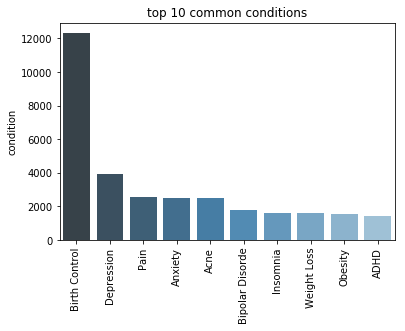

In [7]:
# top 10 common condition
common_condition = drug_train['condition'].value_counts()[:10]
sns.barplot(x=common_condition.index, y=common_condition, data=drug_train, palette="Blues_d")
# plt.bar(common_condition.index, common_condition)
plt.xticks(rotation=90)
plt.title('top 10 common conditions')
plt.show()

Birth Control has occupied most of them. Youngs love it. And the second most is Depression, followed by Anxiety.

Now check the top 10 common drugs:

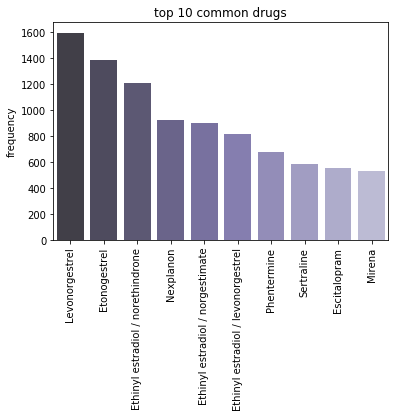

In [8]:
# top 10 common drugs
common_drug = drug_train['drugName'].value_counts()[:10]
sns.barplot(x=common_drug.index, y=common_drug, data=drug_train, palette="Purples_d")
# plt.bar(common_drug.index, common_drug)
plt.xticks(rotation=90)
plt.title('top 10 common drugs')
plt.ylabel('frequency')
plt.show()

Analysis the relation between drugs and conditions: we look at numbers of drugs for top 10 common conditions.

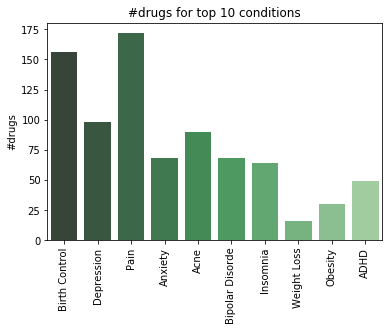

In [9]:
# #drugs for top 10 conditions
selected_data = drug_train[drug_train['condition'].isin(common_condition.index)]
drugs_per_condition = selected_data.groupby(['condition'])['drugName'].nunique()
drugs_per_condition = drugs_per_condition.reindex(common_condition.index)
sns.barplot(x=drugs_per_condition.index, y=drugs_per_condition, data=drug_train, palette="Greens_d")
# plt.bar(drugs_per_condition.index, drugs_per_condition)
plt.xticks(rotation=90)
plt.title('#drugs for top 10 conditions')
plt.ylabel('#drugs')
plt.show()

#### rating distribution

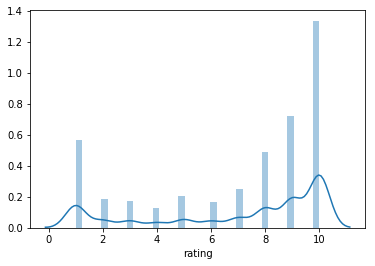

In [10]:
sns.distplot(drug_train['rating']);

#### rating v.s text_length

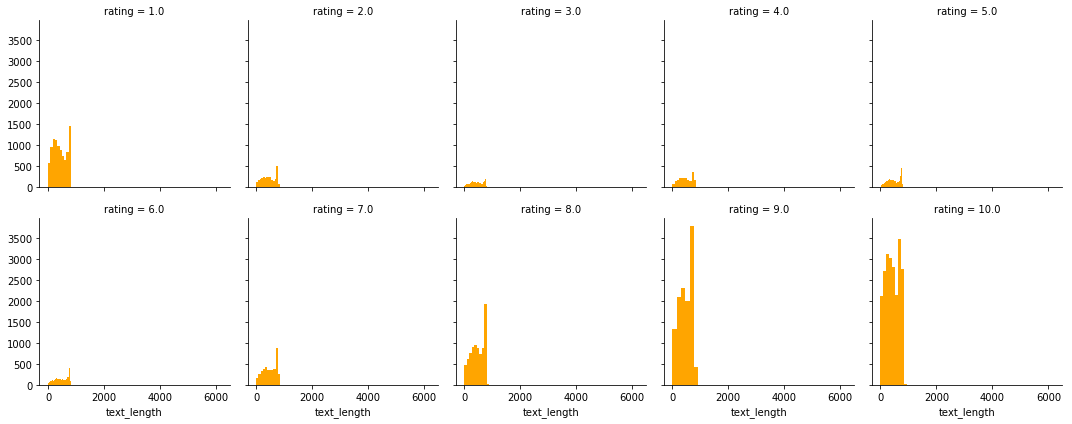

In [11]:
plot = sns.FacetGrid(data=drug_train, col="rating", col_wrap=5)
plot.map(plt.hist, "text_length", bins=40, color="orange")

Seems like overall, the distribution of text length across all 10 ratings are unbalanced. And we can see that reviews center around rating = 1, 8, 9, 10.

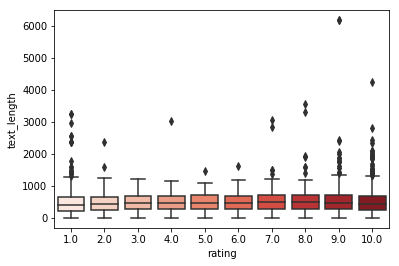

In [12]:
sns.boxplot(data=drug_train, x="rating", y="text_length", palette="Reds")
plt.xlabel('rating')
plt.ylabel('text_length')
plt.show()

There are some extremly long reviews, and I'll deal with these outliers later. But seems like the text length won't be a helpful feature here.

#### review counts v.s date
It shows that numbers of review of each year is growing.

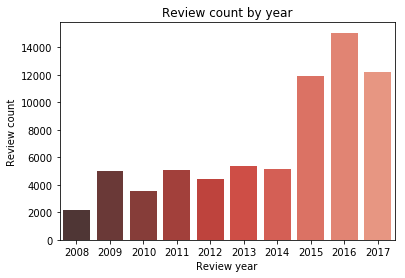

In [13]:
# review counts v.s date
time_series = pd.DataFrame()
time_series['date'] = pd.to_datetime(drug_train['date']).copy()
series_df = drug_train.groupby([time_series.date.dt.year])['review'].count()
# series_df.plot(kind='bar', grid=False)
sns.barplot(x=series_df.index, y=series_df.values, data=drug_train, palette="Reds_d")
plt.title('Review count by year')
plt.xlabel('Review year')
plt.ylabel('Review count')
plt.show()

There's no obvious relationship between them.

#### rating v.s usefulCount

Text(0.5, 1.0, 'rating v.s usefulCount')

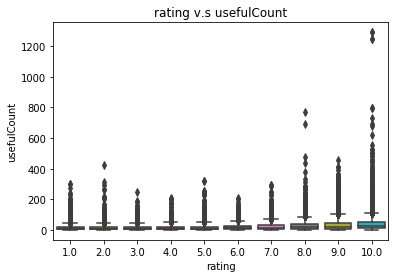

In [14]:
sns.boxplot(x="rating", y="usefulCount", data=drug_train)
plt.title('rating v.s usefulCount')

Looks like usefulCount is quite equally distributed over 10 ratings. Exclude some outliers, people seems to press like button on all kinds of ratings, as long as they feel that the review is useful.

#### rating v.s date
there're 10 classes of rating score, let's simply calculate the mean rating score of each year:

Text(0.5, 1.0, 'Mean rating in year')

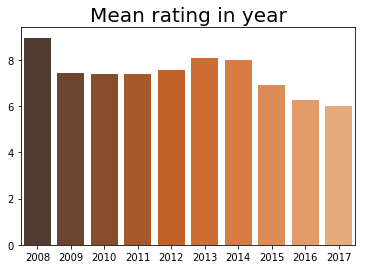

In [15]:
rating = drug_train.groupby([time_series.date.dt.year])['rating'].mean()
# rating.plot(kind="bar", fontsize = 10)
sns.barplot(x=rating.index, y=rating.values, data=drug_train, palette="Oranges_d")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

#### text length v.s rating v.s usefulCount

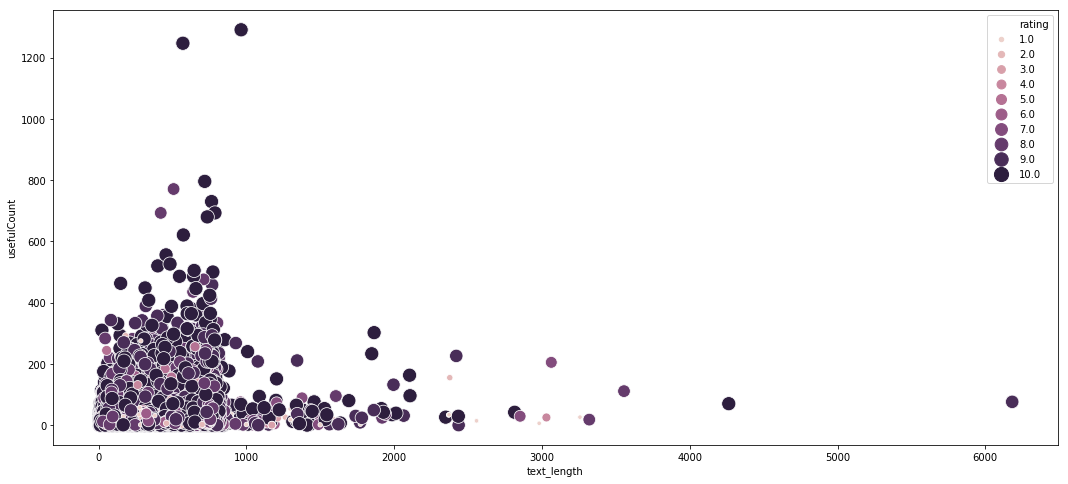

In [16]:
plt.figure(figsize=(18,8))
sns.scatterplot(x="text_length", y="usefulCount", hue="rating", size="rating", legend="full", sizes=(20, 200), data=drug_train)
plt.show()

#### review text
How does a review look like ?

In [17]:
drug_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

Check out the words' frequency

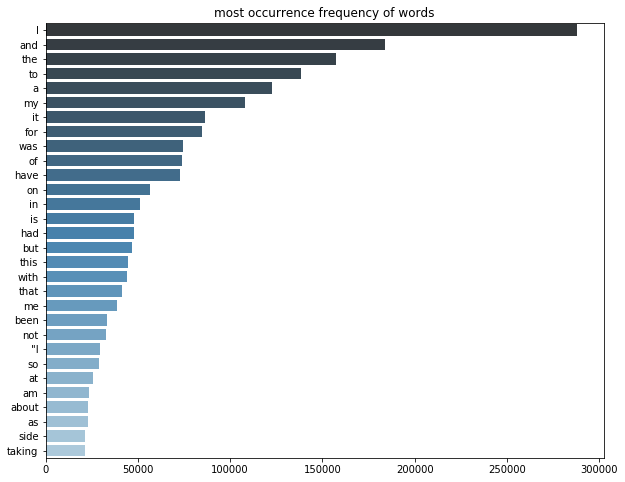

In [18]:
# most occurrence frequency of words
n_words = 30
top_words = drug_train['review'].str.split(expand=True).stack().value_counts()[:n_words]
# word_occurrence = pd.Series(tokens for tokens in drug_train.review.values).value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(x=top_words.values, y=top_words.index, palette="Blues_d")
plt.title("most occurrence frequency of words")
plt.show()

There are so many stopwords and noise up there. We have to clean them. But **sometimes removing stopwords makes the result worse**, we'll discuss this carefully in the later section.

### Correlation
Let us generate some correlation plots of the features to see how related one feature is to the next.

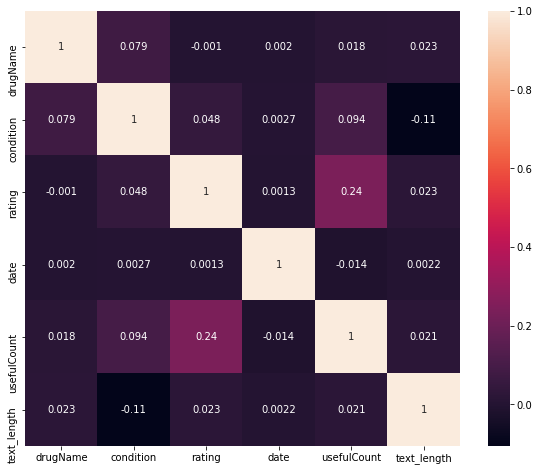

In [19]:
# show correlation matrix
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
corr = drug_train.dropna(axis=0).drop("review", axis=1).apply(lambda x: d[x.name].fit_transform(x).astype('float64')).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True, annot=True)

#### Takeaway from the correlation map
The Correlation plot told us that there are not many features strongly correlated with one another. To be honest, this is a catastrophic and desperate correlation...

At this moment, **I decide only to use review text to predict rating score**. In the improvement section, I'll try to combine other features, but let's wait till that.

## Data preprocessing

### Deal with Nan
Let's check if there's any NAN in the dataset. I'll just simply drop those data.

In [20]:
drug_train.dropna(axis=0, inplace=True)
drug_test.dropna(axis=0, inplace=True)
print('train data:\n', drug_train.isna().sum(), '\n')
print('test data:\n', drug_test.isna().sum())

train data:
 drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
text_length    0
dtype: int64 

test data:
 drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


### Independent & dependent features
Simplify the question for convenience ! I'll convert the 10-classes rating into 3-classes version.

In [21]:
# add rating_simple label according to rating score
# drug_train = drug_train[(drug_train['rating'] < 6) | (drug_train['rating'] > 9)]
# drug_test = drug_test[(drug_test['rating'] < 6) | (drug_test['rating'] > 9)]
simplify_map = {
    1.0: 0.0,
    2.0: 0.0,
    3.0: 0.0,
    4.0: 0.0,
    5.0: 1.0,
    6.0: 1.0,
    7.0: 1.0,
    8.0: 2.0,
    9.0: 2.0,
    10.0: 2.0,
}

drug_train['rating_simple'] = drug_train['rating'].map(simplify_map)
drug_test['rating_simple'] = drug_test['rating'].map(simplify_map)

drug_train['rating_simple'].value_counts()

2.0    42025
0.0    17351
1.0    10206
Name: rating_simple, dtype: int64

In [22]:
drug_test['rating_simple'].value_counts()

2.0    32175
0.0    13428
1.0     7868
Name: rating_simple, dtype: int64

The distribution is still imbalanced. I'll deal with this problem in the later section too.

## Baseline solution
Let me create a quick and dirty solution first. I'll predict rating score based on review text only at first, as it might be the most impactful feature. To do this, I choose to use bag-of-words method, and followed by a classifier.

### Vectorization
We have our reviews as lists of tokens (also known as lemmas). To enable Scikit-learn algorithms to work on our text, we need to convert each review into a vector. The function I'll use here is ```CountVectorizer()```, which counst the frequency of each words and transforms the review text into a sparse matrix.

In [0]:
# import vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Iterable

# a function to flatten dataframe
def flatten(collection):
    for element in collection:
        if isinstance(element, Iterable) and not isinstance(element, str):
            yield from flatten(element)
        else:
            yield element
            
def do_nothing(tokens):
    return tokens

# a function to split dependent & independent variable
def split(train_data, test_data, ngram_range=(1,1), isToken=False):
    
    X_train = drug_train['review']
    X_test = drug_test['review']

    if isToken == False:
        count_vectorizer = CountVectorizer(ngram_range=ngram_range).fit(X_train)
    else:
        count_vectorizer = CountVectorizer(
            ngram_range=ngram_range, 
            tokenizer=do_nothing, 
            preprocessor=do_nothing,
            lowercase=False
        ).fit(X_train)
    X_train = count_vectorizer.transform(X_train)
    X_test = count_vectorizer.transform(X_test)
    
    y_train = drug_train['rating_simple']
    y_test = drug_test['rating_simple']
#     y_train = drug_train['rating']
#     y_test = drug_test['rating']
    
    return X_train, X_test, y_train, y_test

In [24]:
# split dependent & independent variable
X_train, X_test, y_train, y_test = split(drug_train, drug_test)
# print('There are totally', len(count_vectorizer.vocabulary_), 'vocabs.')
print('Shape of training Sparse Matrix:', X_train.shape)
print('Shape of testing Sparse Matrix:', X_test.shape)

Shape of training Sparse Matrix: (69582, 37241)
Shape of testing Sparse Matrix: (53471, 37241)


### Train and evaluate the model
The model I'll use as a text classifier would be **Multinomial Naive Bayes** methoed. It is a very simple and yet powerful method which is widely used to deal with text classification problems.

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

model = MultinomialNB()

# a helper function to train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

train_model(model, X_train, y_train)

Train accuracy: 0.7596073697220546
Test accuracy: 0.7124983635989602


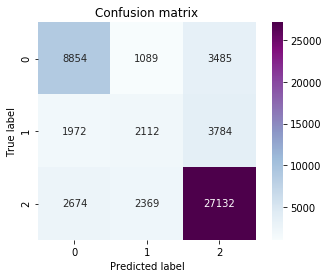

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# a function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', labels=["0", "1", "2"]):
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(cm, annot=True, square=True, fmt='d', cmap="BuPu")
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# a helper function to evaluate model performance
def evaluate(model, x_train, y_train, x_test, y_test):
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    print('Train accuracy: %s' % train_acc)
    print('Test accuracy: %s' % test_acc)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, test_preds)
    plot_confusion_matrix(cm=cm)
    
#     print('Confusion matrix:\n', confusion_matrix(y_test, test_preds))
#     print('\n')
#     print(classification_report(y_test, test_preds))

evaluate(model, X_train, y_train, X_test, y_test)

### Observation and Conclusion
1. There are too many useless information or noise in review text.
2. We can still figure out some useful features.

## Improvement
Now I'll show you some of the possible approaches and the improved results.

### Text cleaning & engineering
Here I perform 5 ways that possibly enhance the accuracy of a Text Classification Model, however, some of them may not. I'll discuss them in detail.
1. Noise Free Corpus (punctuations marks, numerical values, links and urls etc.)
2. Use An Exhaustive Stopword List
3. Eliminating features with extremely low frequency
4. Normalized Corpus (Lemmatization)
5. Use Complex Features (n-grams and part of speech tags)

Let's begin !

In [27]:
# import nltk toolkit
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
drug_train['review'].head()

0    "It has no side effect, I take it in combinati...
1    "My son is halfway through his fourth week of ...
2    "I used to take another oral contraceptive, wh...
3    "This is my first time using any form of birth...
4    "Suboxone has completely turned my life around...
Name: review, dtype: object

### 1. Eliminate Noise
Noisy corpus refers to unimportant entities of the text such as **punctuations marks**, **numerical values**, **links** and **urls** etc. Removal of these entities from the text would increase the accuracy, because size of sample space of possible features set decreases.

In [29]:
import re, string

def eliminate_noise(sentence):
    # remove punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]
    sentence = "".join(nopunc)
    
    # remove mention tag
    sentence = re.sub(r'@\w+', '', sentence)
    
    # remove urls
    sentence = re.sub(r'http.?://[^\s]+[\s]?', '', sentence)
    
    # remove emoji
    sentence.replace('_', '')
    
    # remove digits
    sentence = re.sub('\d+', '', sentence)
    
    # to lower case
    sentence = sentence.lower()
    
    return sentence

drug_train['review'] = drug_train['review'].apply(eliminate_noise)
drug_test['review'] = drug_test['review'].apply(eliminate_noise)
drug_train['review'].head()

0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: review, dtype: object

Train accuracy: 0.7716507142651835
Test accuracy: 0.7220736473976548


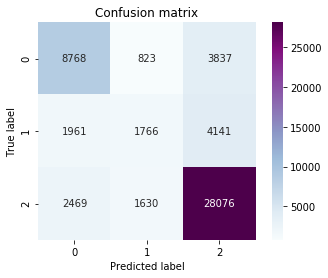

In [30]:
# evaluate performance
X_train, X_test, y_train, y_test = split(drug_train, drug_test)
model = MultinomialNB()
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

The result is better, though just a little bit.

### 2. Remove Stopwords
Stopwords are defined as the most commonly used words in a corpus. Most commonly used stopwords are “a, the, of, on, … etc”. These words are used to define the structure of a sentence. But, are of no use in defining the context. Treating these type of words as feature words would result in poor performance in text classification. These words can be directly ignored from the corpus in order to obtain a better performance. Apart from language stopwords, There are some other supporting words as well which are of lesser importance than any other terms. These includes:
- **Language Stopwords** – a, of, on, the … etc
- **Time Stopwords** – Name of the months and days (january, february, monday, tuesday, today, tomorrow …) etc
- **Numerals Stopwords** – Words describing numerical terms ( hundred, thousand, … etc)
- **Drug name Stopwords** – In this case, also the conditions and drug names

However, this is not the whole story. Sometimes removing stopwords results in worse performance when we're doing Sentiment Analysis. For example:

    "This durg is not good."

This should be a negative rating. If we remove stop words such as **"not"**, it becomes:

    "This drug is good."

and thus happens to be positive result, which is incorrect. 

Therefore, whether to remove stopwords or not depends heavily on dataset. In our case, removing stopwords such as "not"...etc, is not a good approach.

To deal with this, I'll create a customized stopwords list.

In [31]:
# remove stopwords
# # import stopwords from nltk
# stopwords = set(nltk.corpus.stopwords.words('english'))

# # remove some negative words from stopwords list
# not_stopwords = {"n't", "not", "no"}
# filtered_stopwords = set([word for word in stopwords if word not in not_stopwords])

# customized stopwords
# customized_stopwords = {
#     'have', 'on', 'being', 'doing', 'just', 'their', 'until', 'more', 've', 'only', 'haven', 'yourself', 'she', 'now' 'have', 'yourselves', 'you', 'we', "it's", 'at', 'it', 'hers', 'o', 'these', 'does', 'to', 'her', 'y', 'been', 're', 'how', 'they', 'some', 'ours', 'ma', 'will', 'into', 'my', 'by', "she's", 'for', 'myself', 'with', 'again', 'your', 'between', 'herself', 'of', 'out', 'once', 'its', 'a', 'this', 'during', 'each', 'were', 'our', 'or', 'further', "you'll", 's', 'm', 'was', 'is', 'who', 'as', 'll', 'am', 'and', 'them', 'before', 'so', 'own', "you'd", 'about', 'his', 'that', "you've", 'both', 'having', "needn't", 'the', 'where', 'he', 'from', 'are', 'when', 'through', 'be', 'whom', 'do', 'has', 'most', 'against', 'theirs', 'above', 'can', 'ourselves', 'him', 'there', 'did', 'after', 't', 'then', 'than', 'same', 'those', 'd', 'an', 'in', 'himself', 'but', "you're", 'while', 'up', 'me', 'all', 'other', 'here', 'very', 'why', 'under', 'such', 'what', 'i', 'over', 'yours', "that'll", 'because', 'had', 'itself', 'if', 'themselves', 'which'
# }
stopwords = set(nltk.corpus.stopwords.words('english'))
not_stopwords = {"n't", "not", "no"}
customized_stopwords = set([word for word in stopwords if word not in not_stopwords])
for index, row in drug_train.iterrows():
    customized_stopwords.update([x.lower() for x in  word_tokenize(row['drugName'])])
    customized_stopwords.update([x.lower() for x in  word_tokenize(row['condition'])])
    
customized_stopwords.update(['day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years', 'take', 'took', 'taken', 'mg'])

def remove_stopwords(sentence):
    tokened_sentence = word_tokenize(sentence)
#     return [w for w in tokened_sentence if w not in customized_stopwords]
    return " ".join(w for w in tokened_sentence if w not in customized_stopwords)

drug_train['review'] = drug_train['review'].apply(remove_stopwords)
drug_test['review'] = drug_test['review'].apply(remove_stopwords)
drug_train['review'].head()

0                                  no side effect fish
1    son halfway fourth became concerned began last...
2    used another pill cycle happy periods max no s...
3    using form glad went decreased libido subsided...
4    completely turned life around feel healthier e...
Name: review, dtype: object

Train accuracy: 0.7809490960305826
Test accuracy: 0.7237193993005554


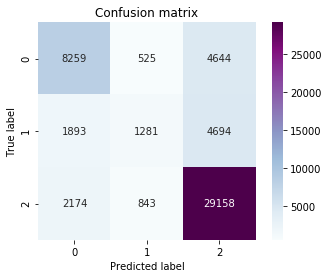

In [32]:
# evaluate performance
X_train, X_test, y_train, y_test = split(drug_train, drug_test)
model = MultinomialNB()
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

### 3. Eliminate words with low frequency
Keywords which occur in lesser frequency in the corpus usually does not play a role in text classification. We can get rid of these low occurring features, resulting in better performance of the model.

In [33]:
# least occurrence frequency of words
n_words = 50
least_words = drug_train['review'].str.split(expand=True).stack().value_counts()[-n_words:]
least_words.index
# plt.figure(figsize=(5, 10))
# sns.barplot(x=least_words.values, y=least_words.index)
# plt.title("50 least occurrence frequency of words")
# plt.show()

Index(['cyproheptad', 'medont', 'omggg', 'siode', 'godsent', 'syprimsthe',
       'quotfeelgoodquot', 'burners', 'overheatingheat', 'aerations',
       'priscribed', 'prozaczoloft', 'specialising', 'shovered',
       'quotmucusquot', 'depressionstarting', 'quottime', 'sleepnight',
       'tachicardia', 'changeover', 'nortripylene', 'effectstoday', 'videoas',
       'anastrozol', 'breach', 'adalumimab', 'suppliers', 'manly', 'swolled',
       'quotalpha', 'solaldi', 'warfrain', 'roofnot', 'gynecology', 'cava',
       'uncover', 'porkchops', 'quotzombied', 'misssing', 'blistersherpes',
       'tradename', 'betteron', 'choiceupon', 'ketones', 'occassionaly',
       'fugue', 'quotlethargic', 'preparedit', 'dilauad', 'excercised'],
      dtype='object')

Let's say, only remove 50 of them who appeared only once:

In [34]:
# eliminate words with low frequency

# threshold = 1
# words_to_remove = dict(word_count[word_count.values <= threshold])
words_to_remove = least_words

def eliminate_lowfreq_words(sentence):
    tokened_sentence = word_tokenize(sentence)
    return " ".join(w for w in tokened_sentence if w not in words_to_remove)

drug_train['review'] = drug_train['review'].apply(eliminate_lowfreq_words)
drug_test['review'] = drug_test['review'].apply(eliminate_lowfreq_words)
drug_train['review'].head()

0                                  no side effect fish
1    son halfway fourth became concerned began last...
2    used another pill cycle happy periods max no s...
3    using form glad went decreased libido subsided...
4    completely turned life around feel healthier e...
Name: review, dtype: object

Train accuracy: 0.780934724497715
Test accuracy: 0.7237568027528941


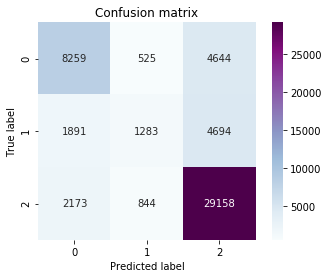

In [35]:
# evaluate performance
X_train, X_test, y_train, y_test = split(drug_train, drug_test)
model = MultinomialNB()
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

### 4.Stemming / Lemmatization
Words are the integral part of any classification technique. However, these words are often used with different variations in the text depending on their grammar (verb, adjective, noun, etc.). For example, the words:
- Playing
- Player
- Plays
- Play
- Players
- Played

In general, stemming and lemmatization group different word types together, and such method is widely used Natural Language Processing tasks. However, it won't always result in better performance.

This results in a higher recall (more true positives) but lower precision (also more false positives) compared to classification without stemming. So if the accuracy is dominated by precision, it will tend to **get worse** with stemming.

In [36]:
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
  
lemmatizer = WordNetLemmatizer() 
porter = PorterStemmer()
sno = SnowballStemmer('english')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatization(sentence):
    tokened_sentence = word_tokenize(sentence)
#     return " ".join(lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokened_sentence)
#     return " ".join(lemmatizer.lemmatize(word) for word in tokened_sentence)
    return " ".join(porter.stem(word) for word in tokened_sentence)
#     return " ".join(sno.stem(word) for word in tokened_sentence)

drug_train['review'] = drug_train['review'].apply(lemmatization)
drug_test['review'] = drug_test['review'].apply(lemmatization)
drug_train['review'].head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


0                                  no side effect fish
1    son halfway fourth becam concern began last st...
2    use anoth pill cycl happi period max no side e...
3    use form glad went decreas libido subsid downs...
4    complet turn life around feel healthier excel ...
Name: review, dtype: object

Train accuracy: 0.7613032106004426
Test accuracy: 0.7133399412765798


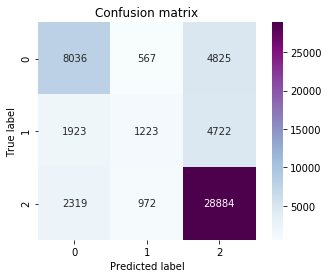

In [37]:
# evaluate performance
X_train, X_test, y_train, y_test = split(drug_train, drug_test)
model = MultinomialNB()
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

As you can see, the accuracy is indeed getting worse.

### 5. N-grams
In some cases, features as the combination of words provides better significance rather than considering single words as features. Combination of N words together are called N-grams. For example:

    "This drug is not good."
    
- 1-gram: "This", "drug", "is", "not", "good"
- 2-grams: "This drug", "drug is", "is not", "not good"
- 3-grams: "This drug is", "drug is not", "is not good"

and so on.

It is known that **Bigrams** (2-grams) are the most informative N-Gram combinations. Adding bigrams to feature set will improve the accuracy of text classification model.

In [0]:
ngram_range = (2, 2)

Train accuracy: 0.9599752809634675
Test accuracy: 0.7578500495595744


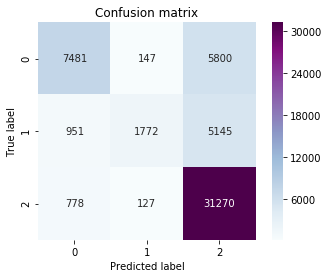

In [39]:
# evaluate performance
X_train, X_test, y_train, y_test = split(drug_train, drug_test, ngram_range=ngram_range)
model = MultinomialNB()
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

Now after cleaning text, I'd like to look at the word frequency again to see the result.

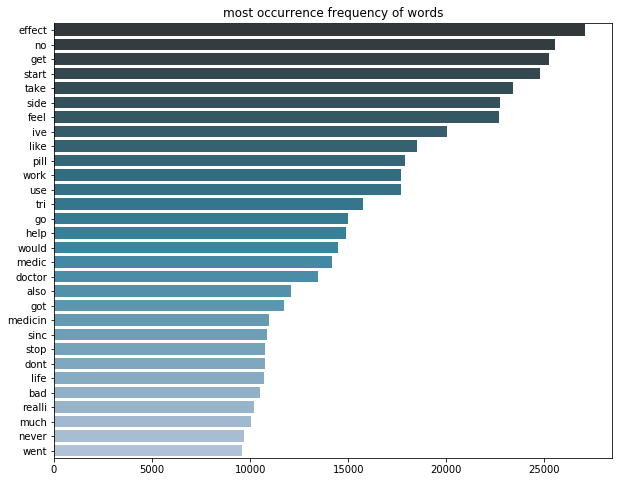

In [40]:
# most occurrence frequency of words
n_words = 30
top_words = drug_train['review'].str.split(expand=True).stack().value_counts()[:n_words]
# word_occurrence = pd.Series(tokens for tokens in drug_train.review.values).value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(x=top_words.values, y=top_words.index, palette="Blues_d")
plt.title("most occurrence frequency of words")
plt.show()

and the word cloud too. Let's look at some positive review words:

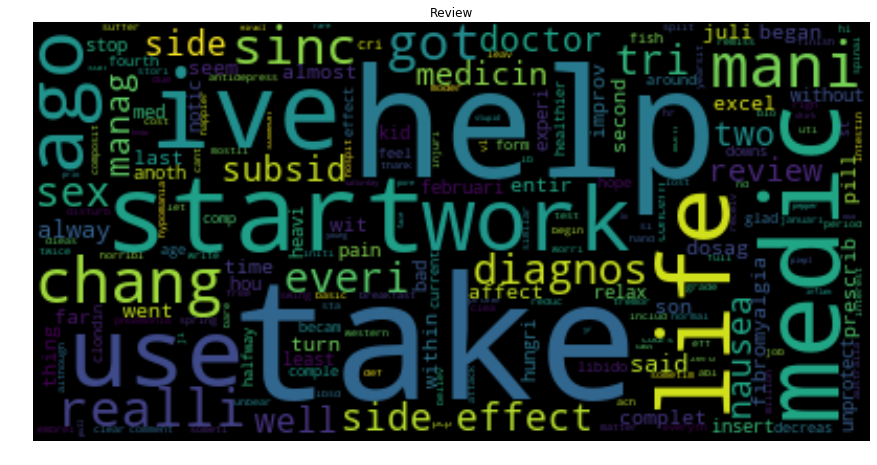

In [41]:
# word cloud
from wordcloud import WordCloud

def plot_wordClouds(words):
    wordcloud = WordCloud().generate(str(words))
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Review')
    plt.axis('off')

positive_review = drug_train[drug_train['rating_simple'] == 2.0]['review']
plot_wordClouds(positive_review)

### Model selection & tuning
Now I want to compare 2 models:
1. Multinomial NB
2. Logistic Regression

,and then use ```GridSearchCV()``` to find the best parameters.

As we saw in the previous analysis, the distribution of rating score is imbalanced, and one way to deal with this is to **penalized the models**, which gives them a different perspective to the problem.

Penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. **These penalties can bias the model to pay more attention to the minority class**. Therefore, we'll definetely try different penalty as parameter.

#### GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# Parameter grid settings for LogisticRegression
lr_params = {
    'C': [0.25, 0.5, 1.0],
    'penalty': ['l1', 'l2']
}

# Parameter grid settings for MultinomialNB
nb_params = {
    'alpha': [0.25, 0.5, 0.75]
}

# # Parameter grid settings for SVC
# svm_params = {
#     'C': [0.25, 0.5, 1.0],
#     'kernel': ['linear', 'poly']
# }

lr = LogisticRegression()
nb = MultinomialNB()
# svm = SVC()

In [43]:
X_train, X_test, y_train, y_test = split(drug_train, drug_test, ngram_range=ngram_range)

# grid search for LogisticRegression
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_params, n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

# grid search for MultinomialNB
nb_grid_search = GridSearchCV(estimator=nb, param_grid=nb_params, n_jobs=-1)
nb_grid_search.fit(X_train, y_train)

# # grid search for SVC
# svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_params, n_jobs=-1)
# svm_grid_search.fit(X_train, y_train)

# extract best parameters
best_lr_params = lr_grid_search.best_params_
best_nb_params = nb_grid_search.best_params_
# best_svm_params = svm_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Test the best parameters for LogisticRegression:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy: 0.9897674685982006
Test accuracy: 0.7744571823979354


{'C': 1.0, 'penalty': 'l2'}

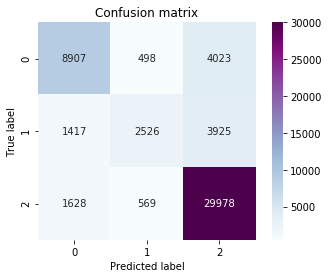

In [44]:
lr = LogisticRegression(**best_lr_params)
train_model(lr, X_train, y_train)
evaluate(lr, X_train, y_train, X_test, y_test)
best_lr_params

Test the best parameters for MultinomialNB:

Train accuracy: 0.9703371561610762
Test accuracy: 0.7648257934207328


{'alpha': 0.75}

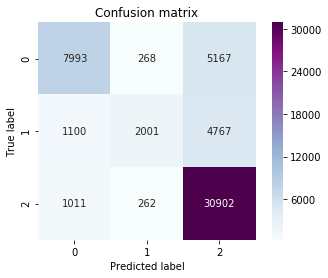

In [45]:
nb = MultinomialNB(**best_nb_params)
train_model(nb, X_train, y_train)
evaluate(nb, X_train, y_train, X_test, y_test)
best_nb_params

#### Observation:
LogisticRegression has better accuracy with fine-tuned parameters.

### More feature engineering & selection
Besides review text, I would like to see if there's still any useful information in the dataset that might help classifying, and then I'll combine them with text feature in the next section.

#### Correlation
Let's quickly take a look at the correlation map again:

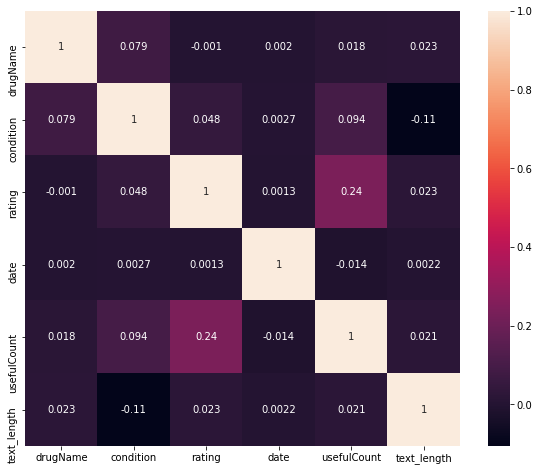

In [46]:
# show correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True, annot=True)

#### Observation
This time, we focus on how dependent features related to our target feature. Seems like the only attribute that'll cause impact on rating score is **"usefulCount"** ! The rest of them doesn't seem helpful.

#### usefulCount
We first dive into this feature to gain more insights.

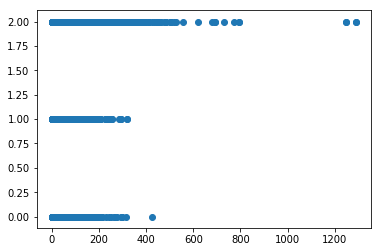

In [47]:
plt.scatter(drug_train['usefulCount'], drug_train['rating_simple'])
plt.show()

Looks like we've got some outliers, let's remove them.

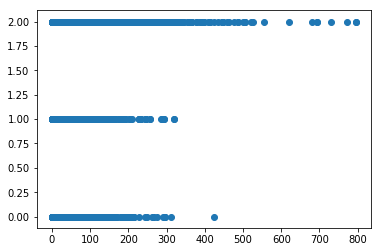

In [48]:
drug_train = drug_train.drop(drug_train[(drug_train['usefulCount'] > 800)].index)
plt.scatter(drug_train['usefulCount'], drug_train['rating_simple'])
plt.show()

**Normalization** usefulCount.

In [0]:
from sklearn import preprocessing

drug_train['usefulCount'] = drug_train['usefulCount'] + 1
drug_test['usefulCount'] = drug_test['usefulCount'] + 1

# normalizr between 0 and 1
maxCount = drug_train['usefulCount'].max()
minCount = drug_train['usefulCount'].min()
def notmilize(x):
    return (x - minCount + 1)*10 / (maxCount - minCount + 1)

# scale the data
# scaler = preprocessing.StandardScaler()
# scaler.fit(drug_train['usefulCount'].values.reshape(-1, 1).astype('float64'))
# drug_train['usefulCount'] = scaler.transform(drug_train['usefulCount'].values.reshape(-1, 1).astype('float64'))
# drug_test['usefulCount'] = scaler.transform(drug_test['usefulCount'].values.reshape(-1, 1).astype('float64'))

# normalizer = preprocessing.Normalizer()
# normalizer.fit(drug_train['usefulCount'].values.reshape(-1, 1).astype('float64'))
# drug_train['usefulCount'] = normalizer.transform(drug_train['usefulCount'].values.reshape(-1, 1).astype('float64'))
# drug_test['usefulCount'] = normalizer.transform(drug_test['usefulCount'].values.reshape(-1, 1).astype('float64'))

drug_train['usefulCount_1to10'] = drug_train['usefulCount'].apply(notmilize)
drug_test['usefulCount_1to10'] = drug_test['usefulCount'].apply(notmilize)

In [50]:
drug_train.head()

,drugName,condition,review,rating,date,usefulCount,text_length,rating_simple,usefulCount_1to10
0,Valsartan,Left Ventricular Dysfunction,no side effect fish,9.0,"May 20, 2012",28,79,2.0,0.351317
1,Guanfacine,ADHD,son halfway fourth becam concern began last st...,8.0,"April 27, 2010",193,741,2.0,2.421581
2,Lybrel,Birth Control,use anoth pill cycl happi period max no side e...,5.0,"December 14, 2009",18,755,1.0,0.225847
3,Ortho Evra,Birth Control,use form glad went decreas libido subsid downs...,8.0,"November 3, 2015",11,448,2.0,0.138018
4,Buprenorphine / naloxone,Opiate Dependence,complet turn life around feel healthier excel ...,9.0,"November 27, 2016",38,719,2.0,0.476788


### Consider usefulCount as a "weight" of review text
So right now, let's add usefulCount into a part of the classifier and see whether it enhances the performance. 
Now, I'm gonna treat each usefulCount as a weight ! We can think of it as a Confidence interval of rating. To do this, I'll **multiply usefulCount into the sparse text metrix**.

In [0]:
# transfer to sparse matrix and split to x and y
# ngram_range = (1, 3)
X_train, X_test, y_train, y_test = split(drug_train, drug_test, ngram_range=ngram_range)

#### Multiply usefulCount with sparse text matrix
We can do this by simply putting all usefulCount at the diagonal of the matrix, and this speeds things up quite a lot.

In [0]:
weight_train = sp.sparse.diags(drug_train.usefulCount, 0) # put usefulCount at diagonal of matrix
X_train = (X_train.T * weight_train).T

weight_test = sp.sparse.diags(drug_test.usefulCount, 0) # put usefulCount at diagonal of matrix
X_test = (X_test.T * weight_test).T

# for row in X_train:
#     print(row)
#     break;

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train accuracy: 0.9861594182069044
Test accuracy: 0.755587140693086


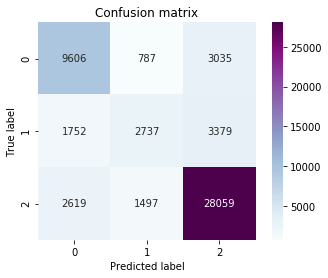

In [53]:
# train and evaluate
model = LogisticRegression(**best_lr_params)
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

#### Observation
Obviously, treating usefulCount as a weight of review text doesn't help. This is probably due to the weak correlation between them.

### Stacking models
Next, I'll build an model by stacking 2 classifiers:
- Text classifier
- Other features classifier.

<img src="https://i.imgur.com/s5ACzN6.png" />

Note that I only use one model in the first layer. This work is aim to combine **sparse text feature** with **dense feature**. Therefore, I first produce a prediction, which is a dense feature, and then combine it with another dense feature, which is usefulCount.

#### A Model Wrapper

In [0]:
from sklearn.model_selection import KFold

# Some useful parameters
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for first-level prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# a helper function to wrap up models
class ModelWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x, y)
        
    def predict_proba(self, x):
        return self.predict_proba(x)

#### First Level Prediction
We can't simply train the first level model with all training data, and then generate prediction on test data for the second layer model, since it might has already known the test data and therefore overfit it badly.

In [0]:
def first_level_prediction(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

#### Base First-Level Models

In [0]:
# Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
#      'warm_start': True,
#     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'max_features' : 'sqrt'
# }
# # AdaBoost parameters
# ada_params = {
#     'n_estimators': 600,
#     'learning_rate' : 0.75
# }

# rf = ModelWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# ada = ModelWrapper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# nb = ModelWrapper(clf=MultinomialNB, seed=SEED, params=best_nb_params)
lr = ModelWrapper(clf=LogisticRegression, seed=SEED, params=best_lr_params)

In [57]:
# Creating NumPy arrays out of our train and test sets
X_train = drug_train['review'] # Creates an array of the train data
y_train = drug_train['rating_simple'].ravel()

count_vectorizer = CountVectorizer(ngram_range=ngram_range).fit(X_train)
X_train = count_vectorizer.transform(X_train)
print(X_train.shape)

X_test = drug_test['review']
X_test = count_vectorizer.transform(X_test)
y_test = drug_test['rating_simple'].ravel()
print(X_test.shape)

(69578, 657567)
(53471, 657567)


#### Output of the First level Predictions

In [58]:
# rf_oof_train, rf_oof_test = first_level_prediction(rf, X_train, y_train, X_test) # Random Forest
# ada_oof_train, ada_oof_test = first_level_prediction(ada, X_train, y_train, X_test) # AdaBoost
# nb_oof_train, nb_oof_test = first_level_prediction(nb, X_train, y_train, X_test) # Multinomial NB
lr_oof_train, lr_oof_test = first_level_prediction(lr, X_train, y_train, X_test) # Logistic Regression

# nb = MultinomialNB()
# nb.fit(X_train, y_train)
# nb_oof_train = nb.predict(X_train).reshape(-1, 1)
# nb_oof_test = nb.predict(X_test).reshape(-1, 1)

# lr = LogisticRegression(**best_lr_params)
# lr.fit(X_train, y_train)
# lr_oof_train = lr.predict(X_train).reshape(-1, 1)
# lr_oof_test = lr.predict(X_test).reshape(-1, 1)

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# rf_oof_train = rf.predict(X_train).reshape(-1, 1)
# rf_oof_test = rf.predict(X_test).reshape(-1, 1)

# ada = AdaBoostClassifier()
# ada.fit(X_train, y_train)
# ada_oof_train = ada.predict(X_train).reshape(-1, 1)
# ada_oof_test = ada.predict(X_test).reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### Add usefulCount to training data

From the first level, we've got a prediction from sparse text feature. Now we combine the dense feature (prediction) with other feature, which is "usefulCount", as a second level classifier's input.

In [59]:
# combine for train data
# X_train = np.concatenate((nb_oof_train/3, drug_train['usefulCount_1to10'].values.reshape(-1, 1)), axis=1)
X_train = np.concatenate((lr_oof_train/3, drug_train['usefulCount_1to10'].values.reshape(-1, 1)), axis=1)

# combine for test data
# X_test = np.concatenate((nb_oof_test/3, drug_test['usefulCount_1to10'].values.reshape(-1, 1)), axis=1)
X_test = np.concatenate((lr_oof_test/3, drug_test['usefulCount_1to10'].values.reshape(-1, 1)), axis=1)

print(X_train.shape)
print(X_test.shape)
X_train

(69578, 2)
(53471, 2)


array([[0.66666667, 0.35131744],
       [0.66666667, 2.42158093],
       [0.        , 0.22584693],
       ...,
       [0.66666667, 0.55207026],
       [0.        , 0.08782936],
       [0.66666667, 1.10414053]])

#### Second-Level Predictions from the First-level Output
Here I choose XGBoost as the second-level classifier. It was built to optimize large-scale boosted tree algorithms, and it's very powerful.

In [0]:
import xgboost as xgb

model = xgb.XGBClassifier(
#     learning_rate=0.02,
#     n_estimators= 2000,
#     max_depth= 4,
#     min_child_weight= 2,
#     gamma=0.9,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread= -1,
#     scale_pos_weight=1
)

Train accuracy: 0.7634740866365806
Test accuracy: 0.7667894746685119


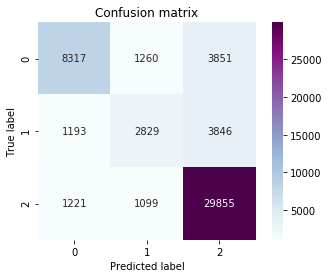

In [61]:
# train and evaluate performance
train_model(model, X_train, y_train)
evaluate(model, X_train, y_train, X_test, y_test)

#### Observation
Still a little worse than 0.77 . Again, I think the main reason is because of the weak correlation between usefulCount and rating score. The distribution of usefulCount scattered all over 3 classes balancely, and thus won't help when predicting rating score.

## Conclusion
That's all the work ! Let's briefly walk through all what we've done in this notebook.

- **Data exploration & understanding**
    - we explored the dataset well to get better understand of it, and found that the only possible feature to predict rating might be review text.
- **Data preprocessing**
    - we converted the text to sparse matrix via counting the frequency of each words.
- **Baseline solution**
    - we predicted rating based on review text only, uning multi-nomial naive bayse method.
- **Improvement**
    - **Text cleaning & engineering**
        - we applied 5 methods, and discussed whether they work or not work.
    - **Model selection & tuning**
        - we tested 2 models, and tried different parameters in order to deal with imbalanced data, and then used the better one in later work.
    - **Feature engineering & selection**
        - we considered features other than review text, and found that usefulCount is the only feature left that might work with review text.
    - **Combine usefulCount with text feature**
        - Consider other feature as a "weight"
            - we multiplied usefulCount as a weight into the sparse text matrix.
        - Stacking model
            - we first produced a prediction based on sparse text matrix, and then combined it with usefulCount as input of second-layer classifier.
       
    
After all these works, I can conclude that review text affects rating score the most, and other features don't really help in our case, a classification of rating score. The heighest accuracy we got is around 77%, by LogisticRegression with parameter C=1 and penalty=l2.

In future works, one may try more different models or more complicated enembling methods and see how they perform. But I'll just stop right here, as the main goal is to analyze the data and show the progress of improvement, and I think that's quite a load of work so far !